In [ ]:
# VarClump2D: Concept test

## _Without optimizations..._

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *

# ACALIB helper functions
sys.path.append('../../ACALIB/')
import acalib
from acalib import load_fits, standarize

# extra metric module
#import custom_metric as cm

## Loading data 2D: Stacking on frequency

In [2]:
"""
Loading data
"""

#fit_path = '../../ACALIB/bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../ACALIB/bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../ACALIB/bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/M100line.image.fits'
#fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../ACALIB/bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data
mask = np.isnan(data)
data = ma.masked_array(data, mask=mask)

# stacking it
data = data.sum(axis=0)
data -= data.min()
data /= data.max()

# generating the data function
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
dfunc = sp.interpolate.interp2d(x, y, data, kind='linear')

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


/home/martin/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


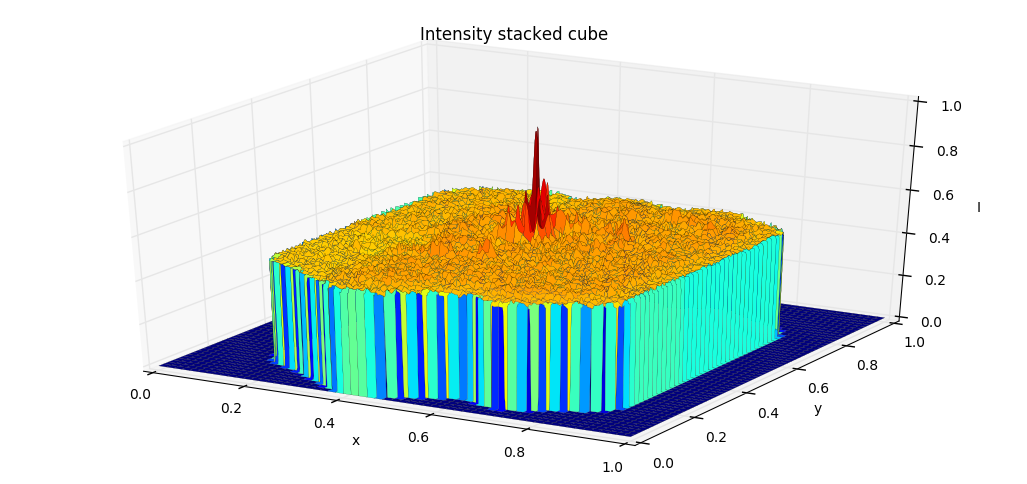

In [3]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

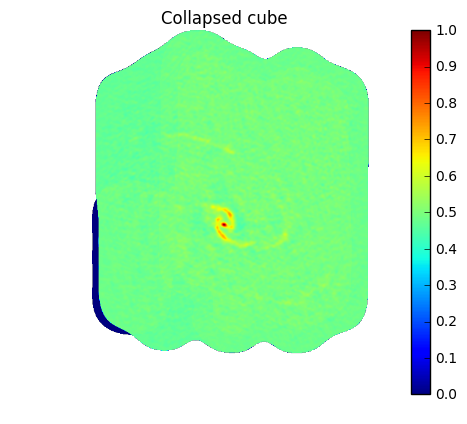

In [4]:
plt.figure(figsize=(5,5))
im = plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

In [5]:
# computing the mask of usable pixels
base_level = 1.1*estimate_rms(data)
umask = data >= base_level
vmask = data >= 0.9*base_level

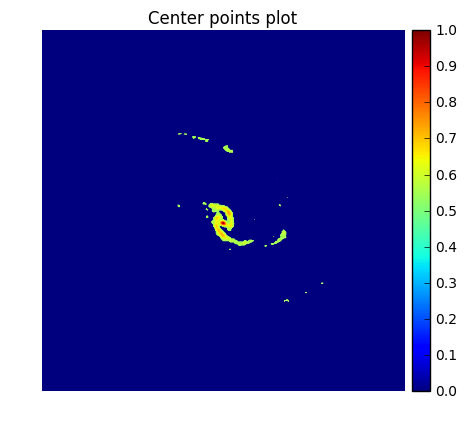

In [6]:
plt.figure(figsize=(5,5))
ax = plt.gca()
_data = np.zeros(data.shape)
mask = data > 1.1*estimate_rms(data)
_data[mask] = data[mask]
im = ax.imshow(_data)
plt.title('Center points plot')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)
plt.show()

In [7]:
# number of points of each type
Nb = 0
Nc = 200
Ne = 2*Nc-4*Nb

In [8]:
centers = random_centers_generation(dfunc, data.shape, 2*Nc, base_level=base_level, power=2.)
center_points = centers[0:Nc]
collocation_points = centers
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

### Visualization of points

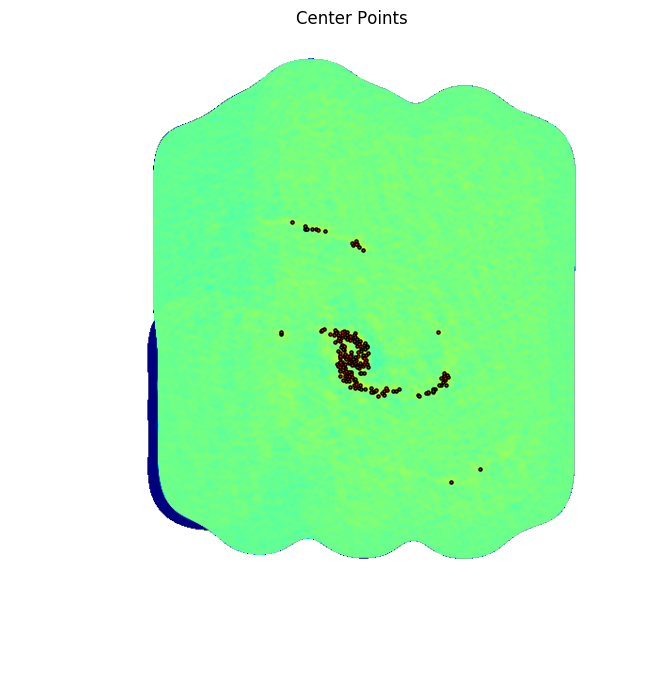

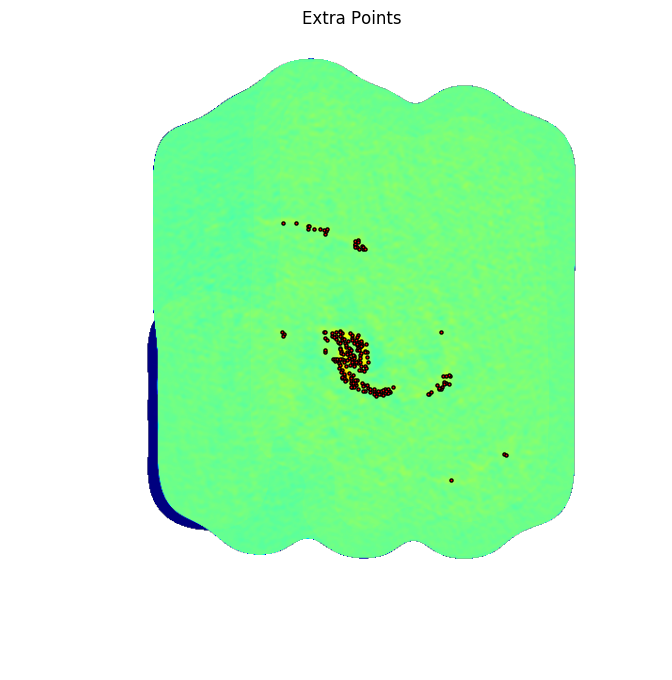

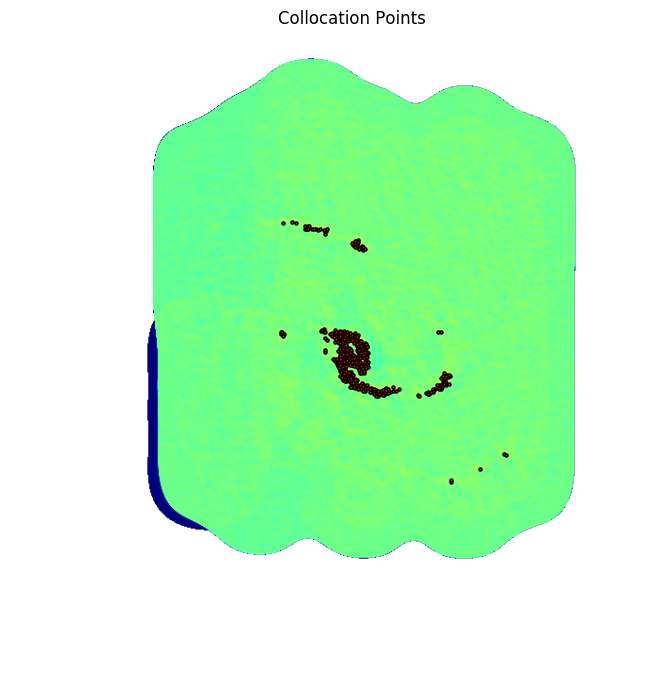

In [9]:
# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=centers[Nc:], title="Extra Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")

## Initial Conditions

In [10]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, method='min_dist')

## Visualizing the initial solution

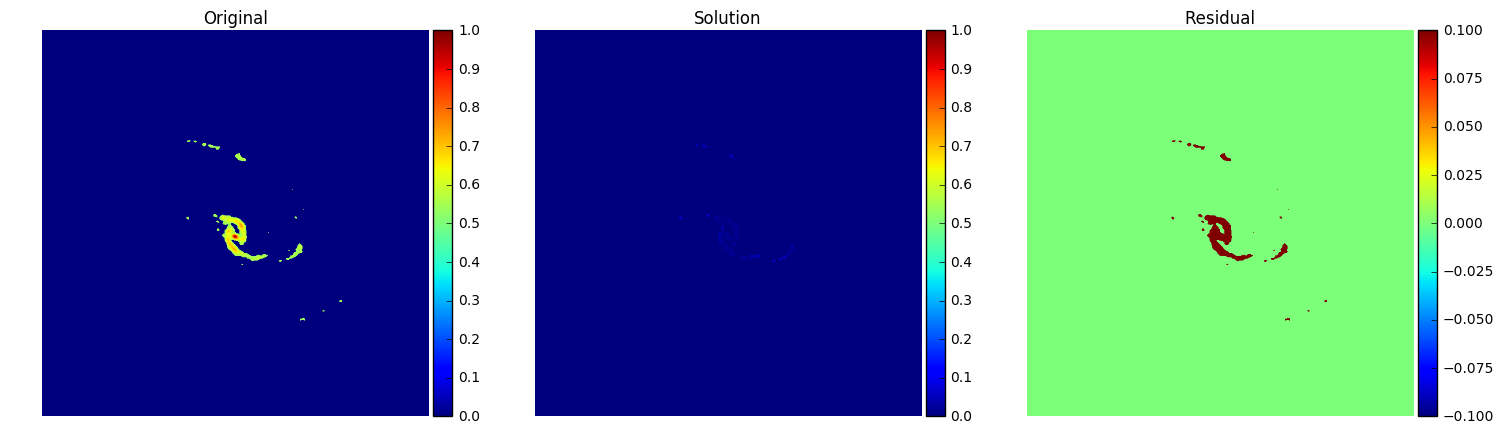

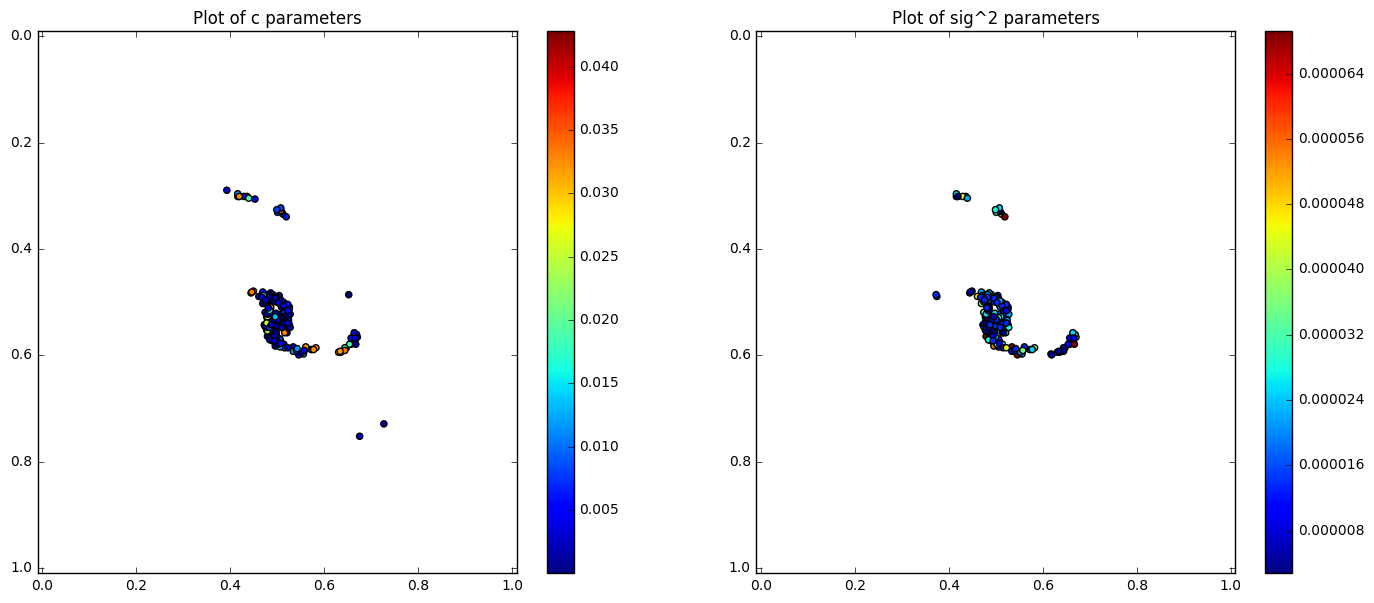

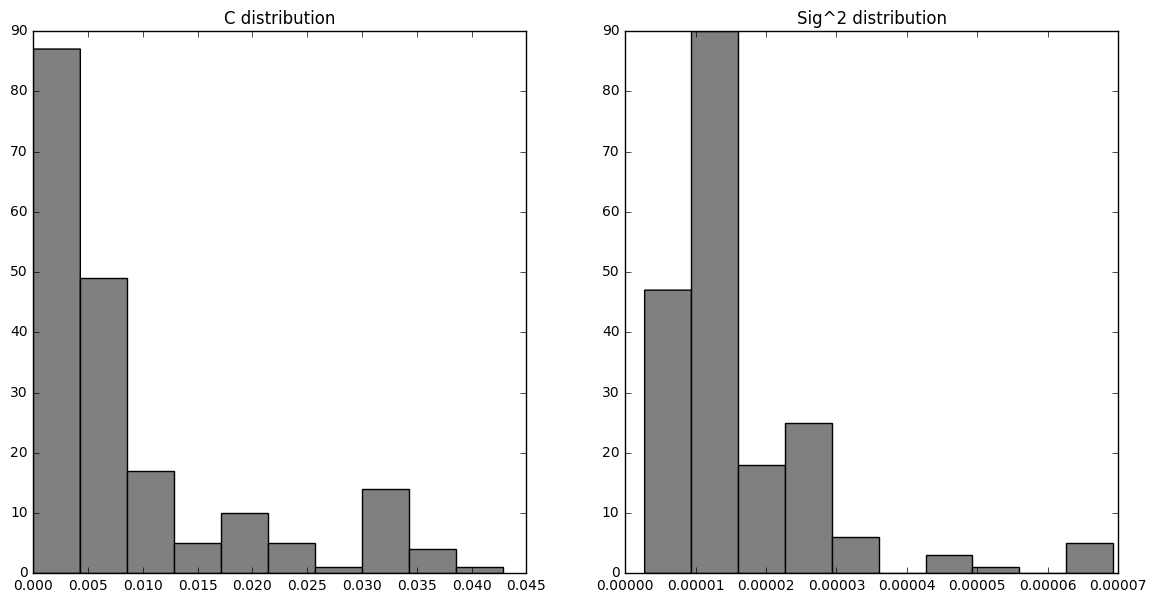

In [12]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=0., mask=umask, compact_supp=True)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

# Experiments

## Experiments 1: With  `base_level=0`
The following instances test with different settings combinations for: square_c and support

In [13]:
"""
ELFunc instantiations
"""

elf01 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=True, compact_supp=True)


elf02 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=False, compact_supp=True)

### C-squared and compact support


##########################################################################################
Results after 1000 iterations
##########################################################################################
Noisy gaussians detected and removed! 

Variation on c = 0.931675334363
variation on sig = 0.952288468975

success: False

status: 5

message: Number of calls to function has reached maxfev = 1000.

nfev: 1207

##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.888196666089
variation on sig = 0.0451080299413

success: False

status: 5

message: Number of calls to function has reached maxfev = 1000.

nfev: 1201

##########################################################################################
Results after 3000 iterations
#######################################################################

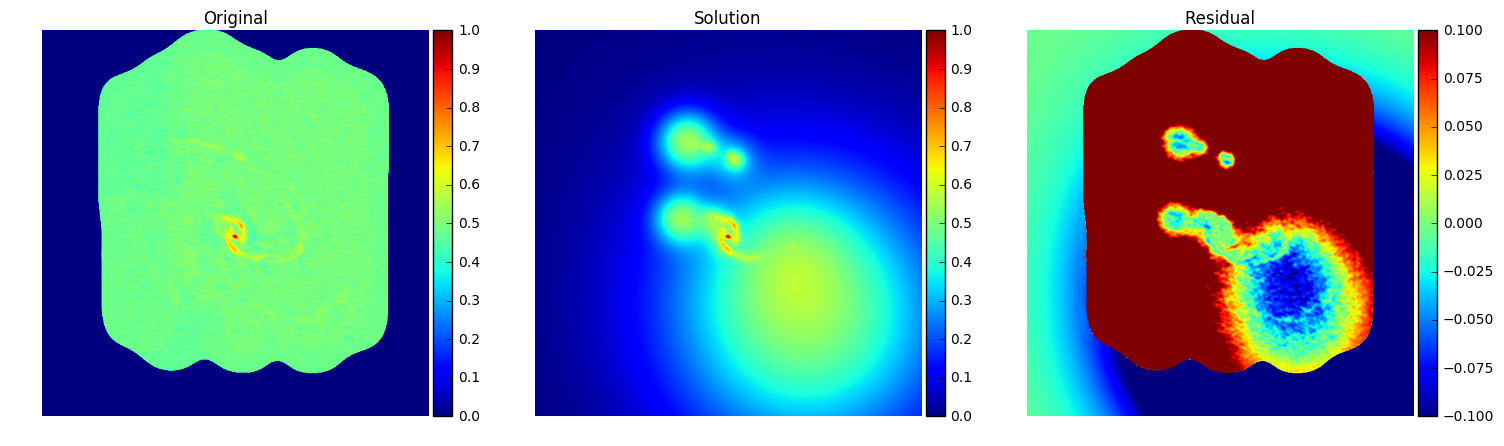

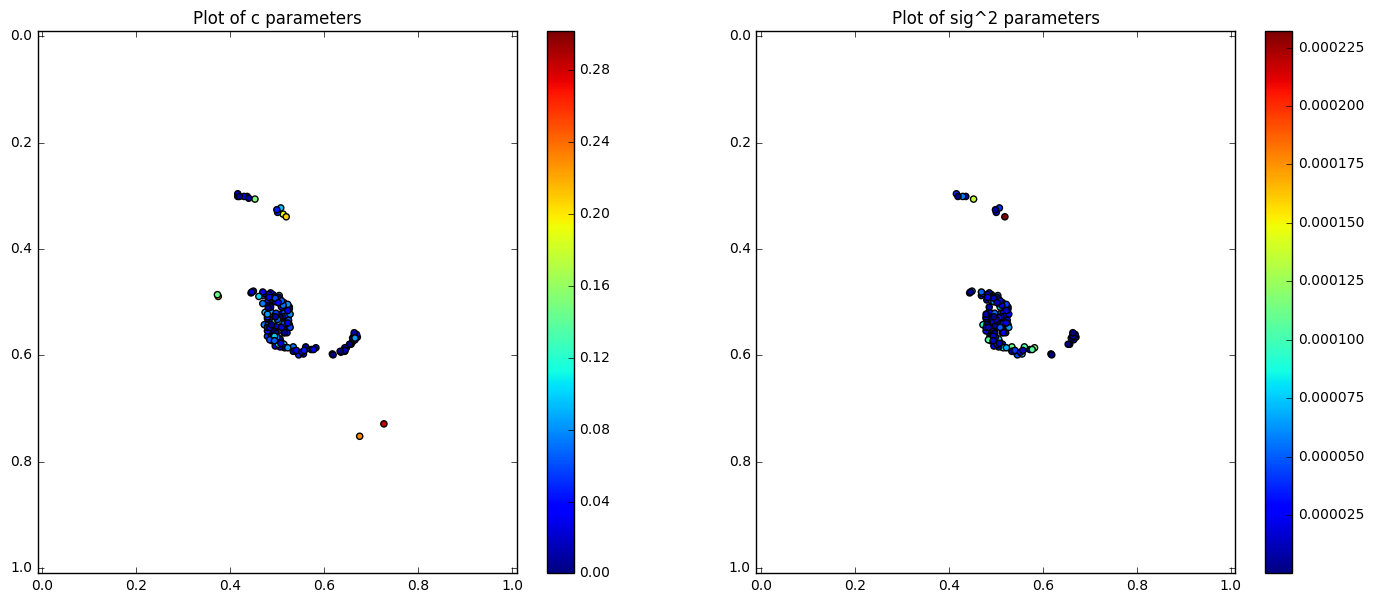

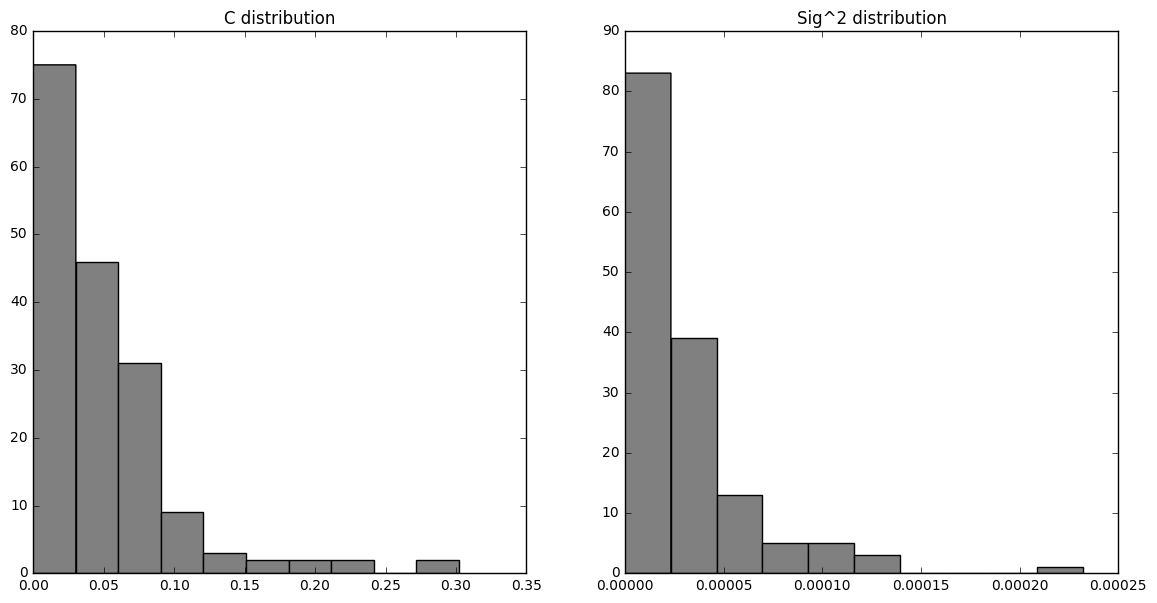

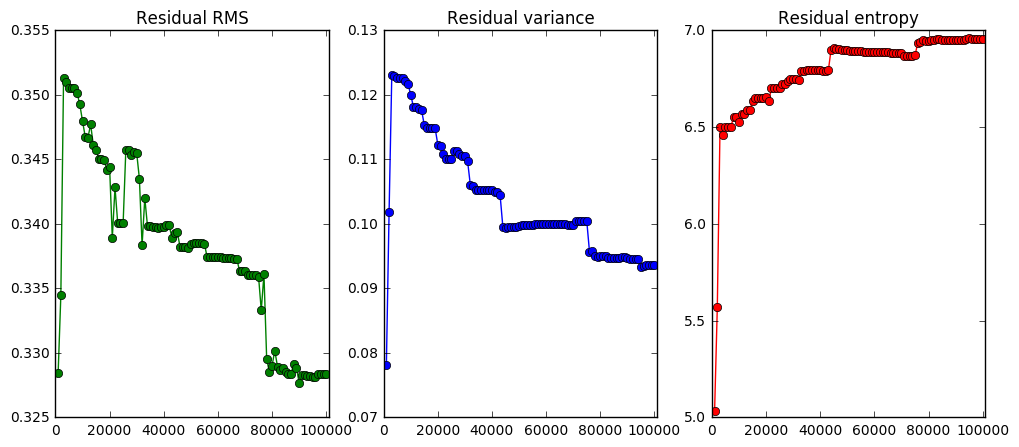

In [12]:
el_solver(elf01, method='exact', step_iter=1000, max_iter=100000)

### C-not squared and compact support


##########################################################################################
Results after 1000 iterations
##########################################################################################
Variation on c = 0.541098476162
variation on sig = 0.80759353839

success: False

status: 5

message: Number of calls to function has reached maxfev = 1000.

nfev: 1207

##########################################################################################
Results after 2000 iterations
##########################################################################################
Noisy gaussians detected and removed! 

Variation on c = 0.667065296332
variation on sig = 2.462465882

success: False

status: 5

message: Number of calls to function has reached maxfev = 1000.

nfev: 1207

##########################################################################################
Results after 3000 iterations
############################################################################

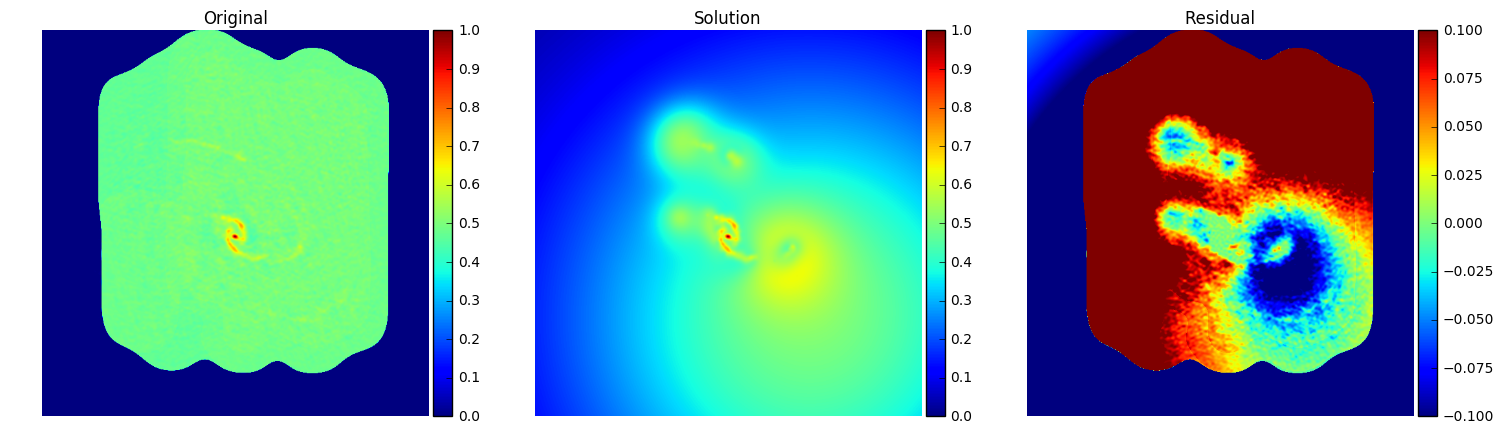

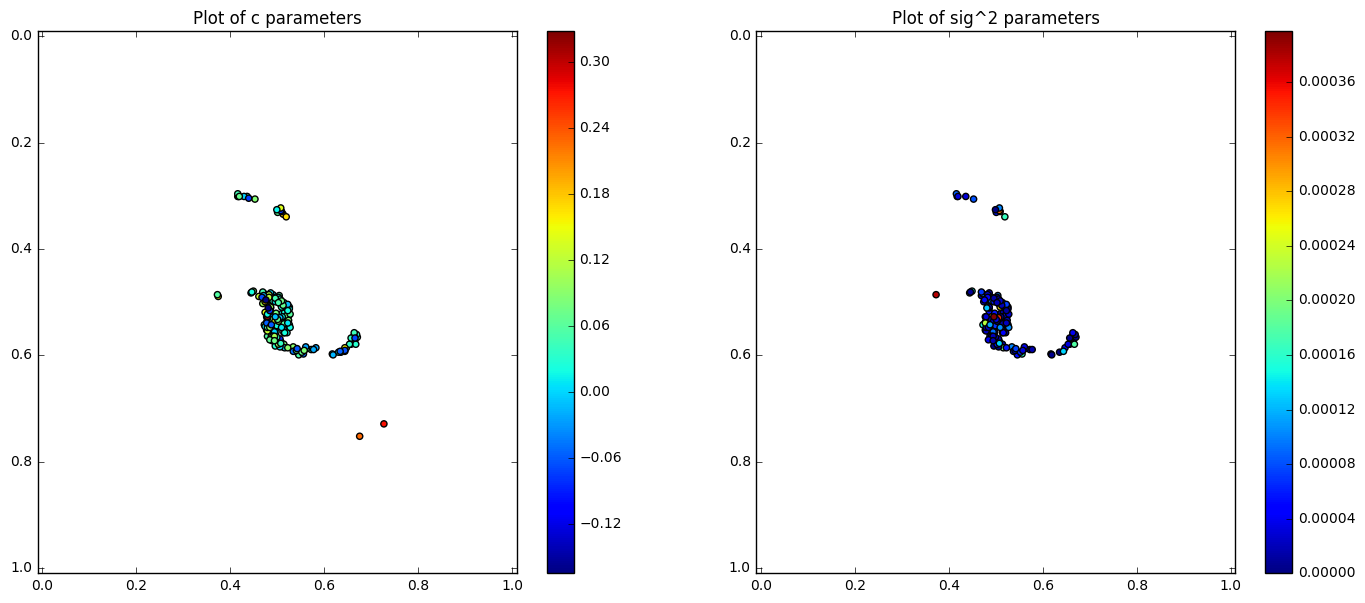

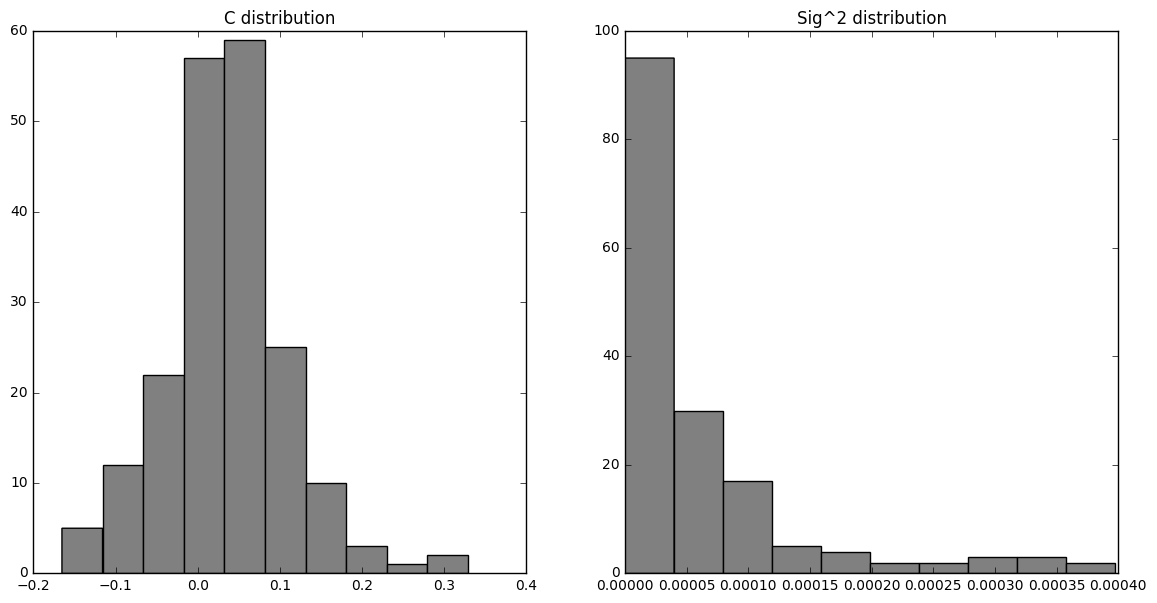

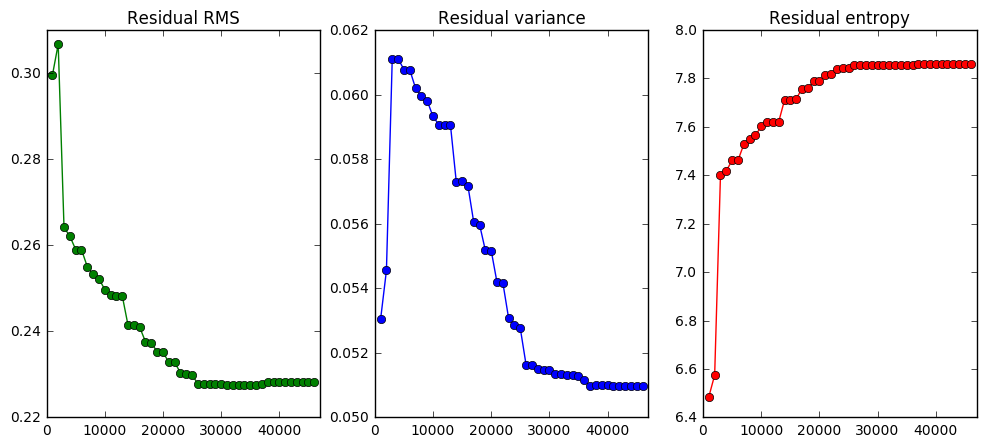

In [13]:
el_solver(elf02, method='exact', step_iter=1000, max_iter=100000)

# Experiments 2: With  `base_level=RMS`
The following instances are tests with different settings combinations for: square_c

In [14]:
elf03 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 2.24055318919
variation on sig = 0.129858024031

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2009

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.0157094715538
variation on sig = 0.00820846544997

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2012

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.

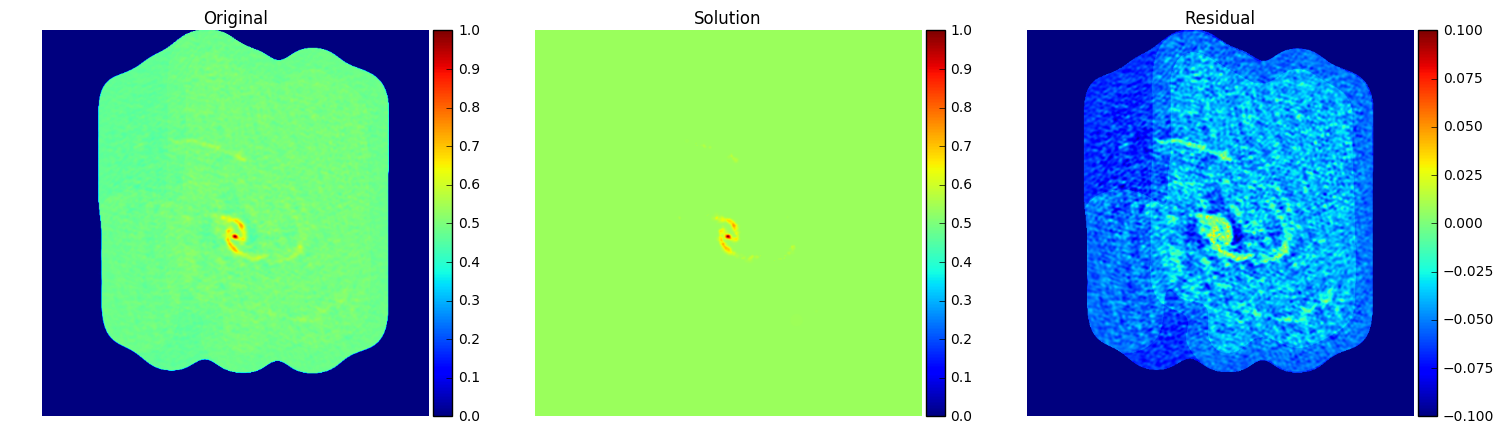

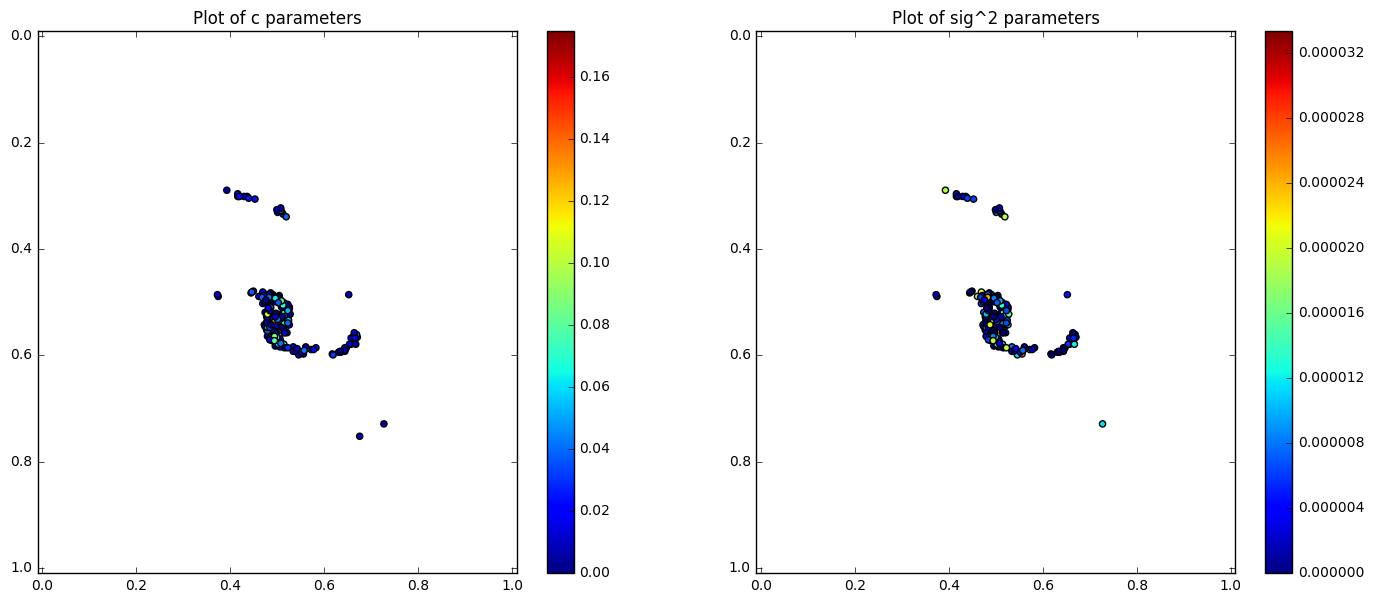

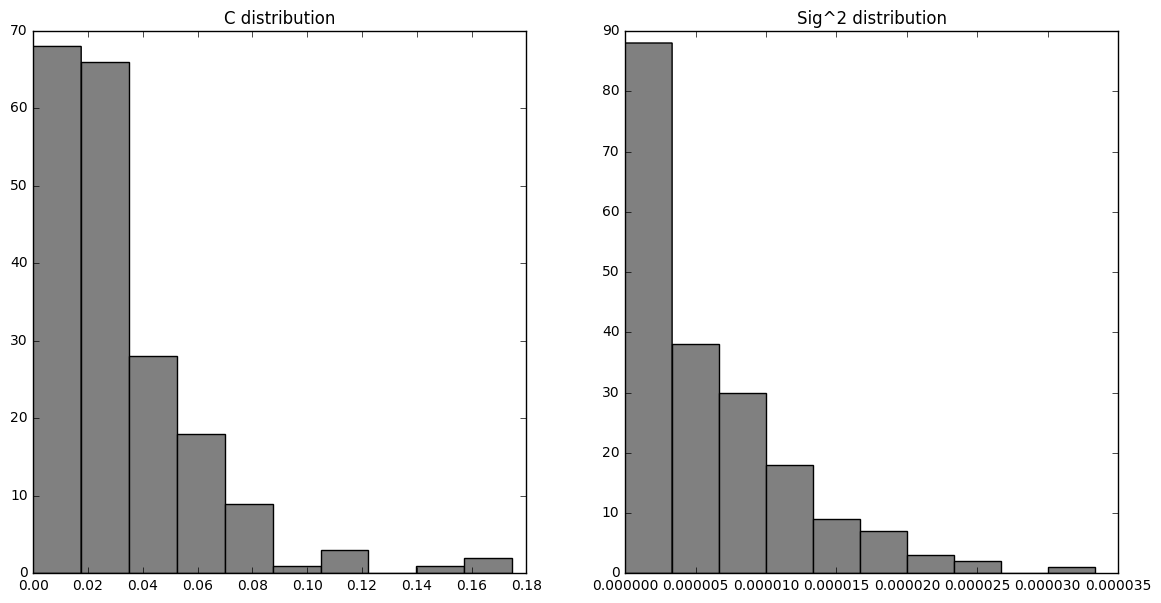

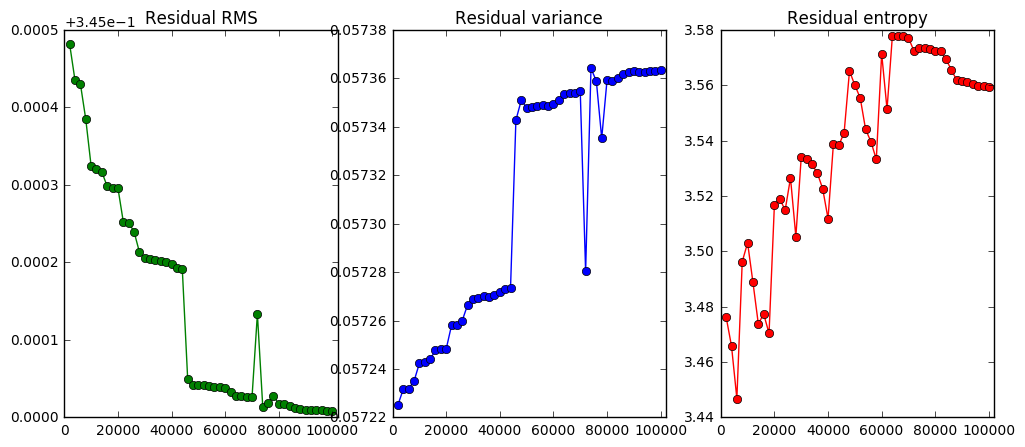

In [15]:
el_solver(elf03, method='exact', step_iter=2000, max_iter=100000, mask=umask)

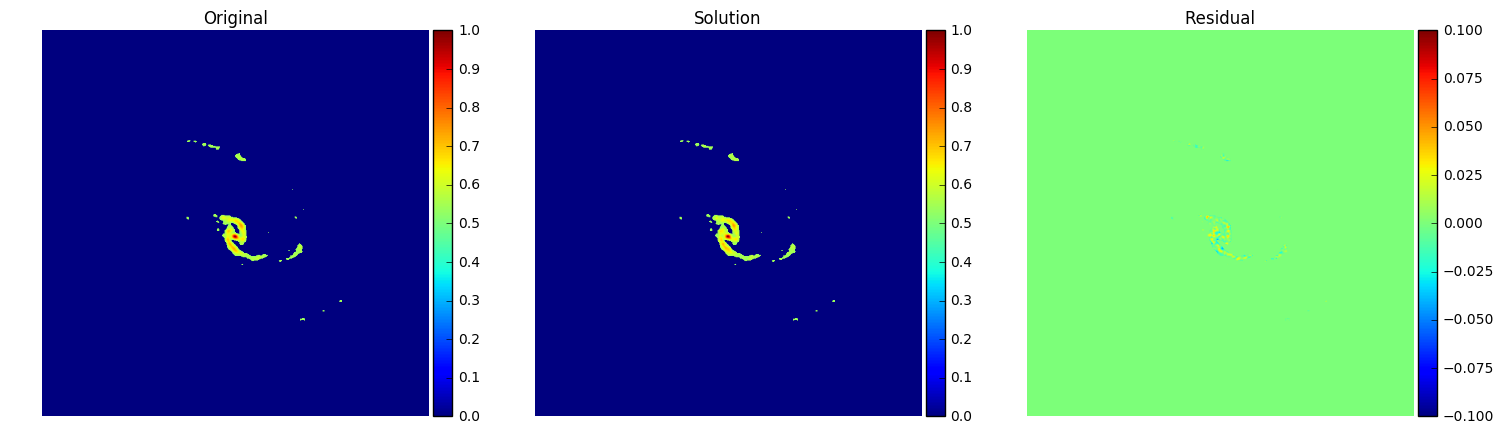

In [16]:
solution_plot(dfunc, elf03.c, elf03.sig, elf03.xc, elf03.yc, dims=elf03.dims, base_level=elf03.base_level,
              mask=umask, square_c=elf03.square_c)